In [ ]:
# Samuel Göbel
# Master Thesis Data Science and Society
# Tilburg University

# Burnout Prediction Among Medical Students


# Experiment 2: Model Perfromance SMOTE-ENN oversampling


In [ ]:

# Overview Experiment 2: --------------------------------



# Target variable ‘burnout’, excluding any mbi-related variables


# Models used: logistic regression, dt, rf, svm, and tabnet


# Stratified 80/20 train/test split


# model training via 5 fold cross validation, applying smote-enn to the training
# folds, not the validation folds.


# randomized hyperparameter tuning via 5 fold cross validation,
# applying smote-enn to the training folds, not the validation folds.


# Train model with best hyperparameters on the entire training set with smote-enn applied


In [ ]:
# required fot SMOTE ENN
! pip install imbalanced-learn

# TabNet
!pip install pytorch-tabnet
# Optuna Tuning
!pip install optuna

In [ ]:
# Standard libraries
import random

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model selection
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split
)

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)

# Imbalanced learning
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

# Deep learning and optimization
import optuna
import torch
from pytorch_tabnet.tab_model import TabNetClassifier


In [ ]:
# using the precprocessed clean data
data = pd.read_csv("/content/drive/MyDrive/Master Thesis 2025/BurnoutDataset/data_encoded_clean.csv")



In [ ]:
# Specifying target and predictors --------------------------------
# Stratified train test split



# Drop MBI-related columns
mbi_columns = ['mbi_ex', 'mbi_cy', 'mbi_ea', 'mbi_total', 'mbi_ea_rev']
df_filtered = data.drop(columns=mbi_columns)

# Define features and target
X = df_filtered.drop(columns=['burnout'])
y = df_filtered['burnout']

# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()


((708, 23),
 (178, 23),
 burnout
 0    680
 1     28
 Name: count, dtype: int64,
 burnout
 0    171
 1      7
 Name: count, dtype: int64)

# Logistic Regression

In [ ]:
# ------------------------------------------------------------------------------
# Logistic Regression
# ------------------------------------------------------------------------------




# pipeline model and smote
pipeline = Pipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])




# hyperparameter search space
param_dist = {
    'logreg__C': np.logspace(-4, 4, 20),
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear']  # required for l1
}




# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Hyperparameter tuning with RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)





# Fit model (tuning + training inside CV folds)
search.fit(X_train, y_train)





# print best parameters
best_params = search.best_params_
print("Best hyperparameters:", best_params)



# retrain best logreg model on entire train set oversampled
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

final_model = LogisticRegression(
    C=best_params['logreg__C'],
    penalty=best_params['logreg__penalty'],
    solver=best_params['logreg__solver'],
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
final_model.fit(X_train_resampled, y_train_resampled)






# Evaluate on TRAINING set
y_train_pred = final_model.predict(X_train_resampled)
y_train_proba = final_model.predict_proba(X_train_resampled)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train_resampled, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled, y_train_pred):.4f}")




# Evaluate on TEST set
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nTest Performance:")
print(classification_report(y_test, y_pred))
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__C': np.float64(0.23357214690901212)}

Training Performance:
Precision: 0.9310
Recall: 0.9529
F1 Score: 0.9419
ROC AUC: 0.9792
Cohen’s Kappa: 0.8661

Test Performance:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       171
           1       0.14      0.71      0.24         7

    accuracy                           0.82       178
   macro avg       0.56      0.77      0.57       178
weighted avg       0.95      0.82      0.87       178

Precision: 0.1429
Recall: 0.7143
F1 Score: 0.2381
ROC AUC: 0.7527
Cohen’s Kappa: 0.1847

Confusion Matrix:
 [[141  30]
 [  2   5]]


ROC AUC: 0.7527


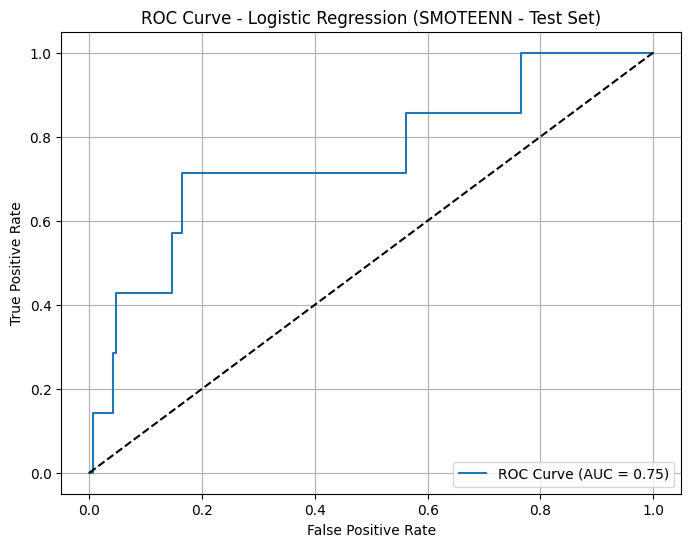

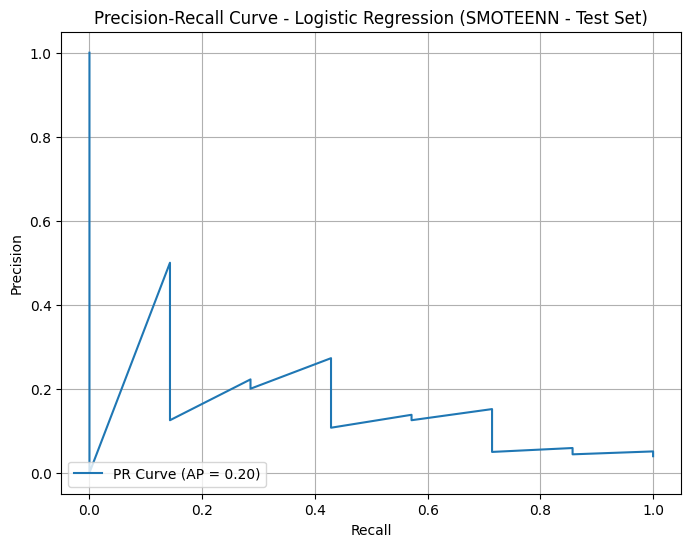

In [ ]:
# LogReg ROC_AUC and PR Curve visualization
# ------------------------------------------------------



# refitting to total trianing set with the best hyperparameters.


smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)


# best LOgReg Model-------

best_log_reg = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    C=np.float64(0.23357214690901212),
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

best_log_reg.fit(X_train_resampled, y_train_resampled)







# Predict class probabilities for test set
y_proba = best_log_reg.predict_proba(X_test)[:, 1]

# Predict hard class labels
y_pred = best_log_reg.predict(X_test)





# -------------------------------

# ROC-AUC Visualization

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")


# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (SMOTEENN - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# -----------------------------
# Plot PR Curve



# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute Average Precision score
ap_score = average_precision_score(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression (SMOTEENN - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()



# Decision Tree

In [ ]:
# ------------------------------------------------------------------------------
# Decision Tree
# ------------------------------------------------------------------------------


# Model and smote pipeline
dt_pipeline = Pipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('dt', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])




# hyperparameter search space
dt_param_dist = {
    'dt__max_depth': [None, 5, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__criterion': ['gini', 'entropy']
}



# define search sapace and cv
dt_search = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=dt_param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,  # same StratifiedKFold
    verbose=1,
    random_state=42,
    n_jobs=-1
)





# Fit model (tuning + training inside folds)
dt_search.fit(X_train, y_train)




# best parameters
best_dt_params = dt_search.best_params_
print("Best hyperparameters:", best_dt_params)





# Retrain model on full training data with SMOTE-ENN
X_train_resampled_dt, y_train_resampled_dt = smoteenn.fit_resample(X_train, y_train)

final_dt = DecisionTreeClassifier(
    max_depth=best_dt_params['dt__max_depth'],
    min_samples_split=best_dt_params['dt__min_samples_split'],
    min_samples_leaf=best_dt_params['dt__min_samples_leaf'],
    criterion=best_dt_params['dt__criterion'],
    class_weight='balanced',
    random_state=42
)
final_dt.fit(X_train_resampled_dt, y_train_resampled_dt)





# Evaluate on TRAINING set
y_train_pred_dt = final_dt.predict(X_train_resampled_dt)
y_train_proba_dt = final_dt.predict_proba(X_train_resampled_dt)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled_dt, y_train_pred_dt):.4f}")
print(f"Recall: {recall_score(y_train_resampled_dt, y_train_pred_dt):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled_dt, y_train_pred_dt):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled_dt, y_train_proba_dt):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled_dt, y_train_pred_dt):.4f}")




# Evaluate on TEST set
y_pred_dt = final_dt.predict(X_test)
y_proba_dt = final_dt.predict_proba(X_test)[:, 1]

precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
cohen_kappa_dt = cohen_kappa_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("\nTest Performance:")
print(classification_report(y_test, y_pred_dt))
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print(f"ROC AUC: {roc_auc_dt:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_dt:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_dt)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'dt__min_samples_split': 2, 'dt__min_samples_leaf': 1, 'dt__max_depth': 10, 'dt__criterion': 'gini'}

Training Performance:
Precision: 0.9942
Recall: 1.0000
F1 Score: 0.9971
ROC AUC: 0.9993
Cohen’s Kappa: 0.9933

Test Performance:
              precision    recall  f1-score   support

           0       0.98      0.89      0.94       171
           1       0.18      0.57      0.28         7

    accuracy                           0.88       178
   macro avg       0.58      0.73      0.61       178
weighted avg       0.95      0.88      0.91       178

Precision: 0.1818
Recall: 0.5714
F1 Score: 0.2759
ROC AUC: 0.7364
Cohen’s Kappa: 0.2299

Confusion Matrix:
 [[153  18]
 [  3   4]]


ROC AUC (Decision Tree): 0.7364


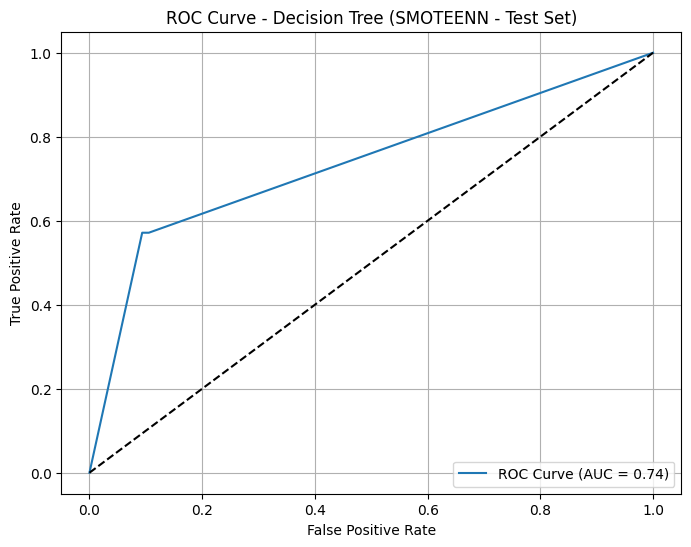

Average Precision (AP) (Decision Tree): 0.1311


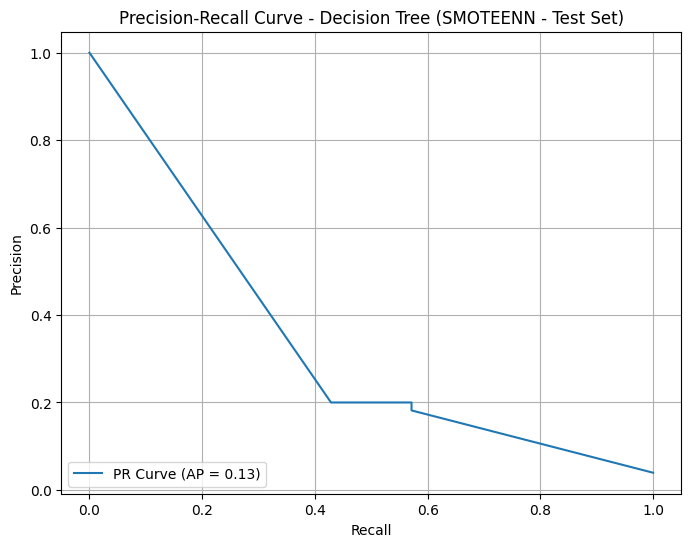

In [ ]:
# ------------------------------------------------------
# Decision Tree ROC_AUC and PR Curve visualization
# ------------------------------------------------------


# refitting to full training set with the best hyperparameters




# Resample training set with SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled_dt, y_train_resampled_dt = smoteenn.fit_resample(X_train, y_train)




# best Decision Tree model
best_dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    criterion='gini',
    class_weight='balanced',
    random_state=42
)




# Fit model
best_dt.fit(X_train_resampled_dt, y_train_resampled_dt)




# Predict on the test set
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]





# ------------------------------------------------------
# ROC-AUC Visualization


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
print(f"ROC AUC (Decision Tree): {roc_auc_dt:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (SMOTEENN - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# ------------------------------------------------------
# Precision-Recall Curve Visualization


# Compute Precision-Recall curve
precision_dt, recall_dt, thresholds_pr = precision_recall_curve(y_test, y_proba_dt)



# Compute Average Precision score
ap_score_dt = average_precision_score(y_test, y_proba_dt)
print(f"Average Precision (AP) (Decision Tree): {ap_score_dt:.4f}")



# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_dt, precision_dt, label=f'PR Curve (AP = {ap_score_dt:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Decision Tree (SMOTEENN - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# Random Forest

In [ ]:
# ------------------------------------------------------------------------------
# Random Forest
# ------------------------------------------------------------------------------




# define pipeline
rf_pipeline = Pipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])



# define hyperparameter search space
rf_param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}



# randomizedSearchCV with Stratified 5-Fold CV
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,  # same StratifiedKFold
    verbose=1,
    random_state=42,
    n_jobs=-1
)





# fit model (tuning + training inside folds)
rf_search.fit(X_train, y_train)





# best parameters
best_rf_params = rf_search.best_params_
print("Best hyperparameters:", best_rf_params)




# retrain model on full training data with SMOTE-ENN
X_train_resampled_rf, y_train_resampled_rf = smoteenn.fit_resample(X_train, y_train)

final_rf = RandomForestClassifier(
    n_estimators=best_rf_params['rf__n_estimators'],
    max_depth=best_rf_params['rf__max_depth'],
    min_samples_split=best_rf_params['rf__min_samples_split'],
    min_samples_leaf=best_rf_params['rf__min_samples_leaf'],
    bootstrap=best_rf_params['rf__bootstrap'],
    class_weight='balanced',
    random_state=42
)

final_rf.fit(X_train_resampled_rf, y_train_resampled_rf)






# Evaluate on TRAINING set
y_train_pred_rf = final_rf.predict(X_train_resampled_rf)
y_train_proba_rf = final_rf.predict_proba(X_train_resampled_rf)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled_rf, y_train_pred_rf):.4f}")
print(f"Recall: {recall_score(y_train_resampled_rf, y_train_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled_rf, y_train_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled_rf, y_train_proba_rf):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled_rf, y_train_pred_rf):.4f}")






# Evaluate on TEST set
y_pred_rf = final_rf.predict(X_test)
y_proba_rf = final_rf.predict_proba(X_test)[:, 1]

precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
cohen_kappa_rf = cohen_kappa_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("\nTest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"ROC AUC: {roc_auc_rf:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_rf:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_rf)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 20, 'rf__bootstrap': False}

Training Performance:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Cohen’s Kappa: 1.0000

Test Performance:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       171
           1       0.27      0.43      0.33         7

    accuracy                           0.93       178
   macro avg       0.62      0.69      0.65       178
weighted avg       0.95      0.93      0.94       178

Precision: 0.2727
Recall: 0.4286
F1 Score: 0.3333
ROC AUC: 0.8755
Cohen’s Kappa: 0.2997

Confusion Matrix:
 [[163   8]
 [  4   3]]


ROC AUC (Random Forest): 0.8755


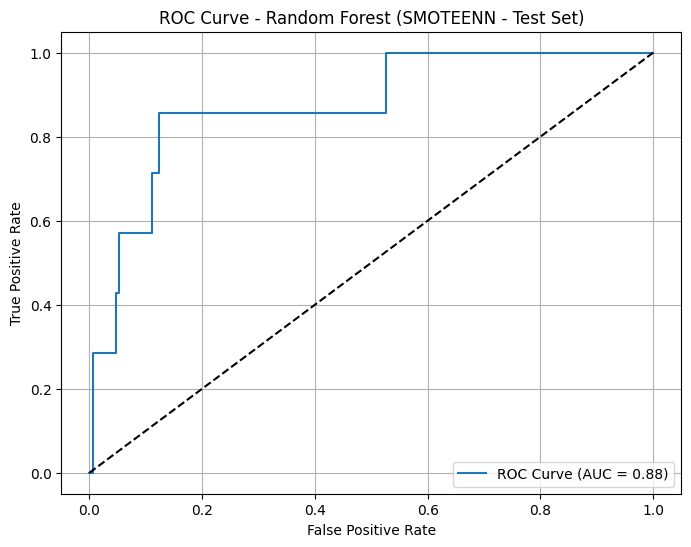

Average Precision (AP) (Random Forest): 0.3214


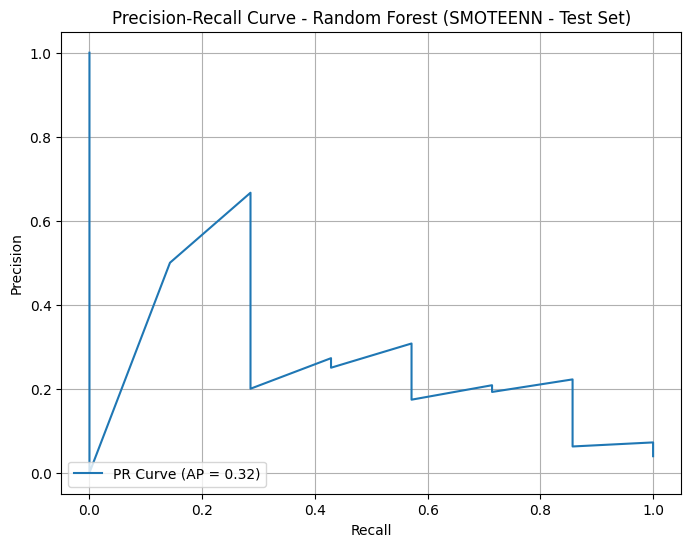

In [ ]:
# Random Forest ROC_AUC and PR Curve visualization
# ------------------------------------------------------


# refitting to full training set with the best hyperparameters




# resample training set with SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled_rf, y_train_resampled_rf = smoteenn.fit_resample(X_train, y_train)



# define best Random Forest model
best_rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=2,
    max_depth=20,
    bootstrap=False,
    class_weight='balanced',
    random_state=42
)



# fit model
best_rf.fit(X_train_resampled_rf, y_train_resampled_rf)



# predict on the test set
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]




# ------------------------------------------------------
# ROC-AUC Visualization


# Compute ROC curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"ROC AUC (Random Forest): {roc_auc_rf:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (SMOTEENN - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





# ------------------------------------------------------
# Precision-Recall Curve Visualization


# Compute Precision-Recall curve
precision_rf, recall_rf, thresholds_pr_rf = precision_recall_curve(y_test, y_proba_rf)

# Compute Average Precision score
ap_score_rf = average_precision_score(y_test, y_proba_rf)
print(f"Average Precision (AP) (Random Forest): {ap_score_rf:.4f}")

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'PR Curve (AP = {ap_score_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest (SMOTEENN - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# SVM

In [ ]:
# ------------------------------------------------------------------------------
# Support Vector Machine (SVM)
# ------------------------------------------------------------------------------



# pipeline
svm_pipeline = Pipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42))
])



# hyperparameter search space
svm_param_dist = {
    'svm__C': np.logspace(-3, 3, 10),
    'svm__gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5)),
    'svm__kernel': ['rbf']
}




# cv 5 folds
svm_search = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=svm_param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,  # same StratifiedKFold
    verbose=1,
    random_state=42,
    n_jobs=-1
)




# fit model (tuning + training inside folds)
svm_search.fit(X_train, y_train)




# best parameters
best_svm_params = svm_search.best_params_
print("Best hyperparameters:", best_svm_params)




# retrain model on full training data with SMOTE-ENN
X_train_resampled_svm, y_train_resampled_svm = smoteenn.fit_resample(X_train, y_train)

final_svm = SVC(
    C=best_svm_params['svm__C'],
    gamma=best_svm_params['svm__gamma'],
    kernel=best_svm_params['svm__kernel'],
    class_weight='balanced',
    probability=True,
    random_state=42
)

final_svm.fit(X_train_resampled_svm, y_train_resampled_svm)





# Evaluate on TRAINING set
y_train_pred_svm = final_svm.predict(X_train_resampled_svm)
y_train_proba_svm = final_svm.predict_proba(X_train_resampled_svm)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled_svm, y_train_pred_svm):.4f}")
print(f"Recall: {recall_score(y_train_resampled_svm, y_train_pred_svm):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled_svm, y_train_pred_svm):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled_svm, y_train_proba_svm):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled_svm, y_train_pred_svm):.4f}")





# Evaluate on TEST set
y_pred_svm = final_svm.predict(X_test)
y_proba_svm = final_svm.predict_proba(X_test)[:, 1]

precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)
cohen_kappa_svm = cohen_kappa_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print("\nTest Performance:")
print(classification_report(y_test, y_pred_svm))
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")
print(f"ROC AUC: {roc_auc_svm:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_svm:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_svm)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'svm__kernel': 'rbf', 'svm__gamma': 'auto', 'svm__C': np.float64(0.1)}

Training Performance:
Precision: 0.9262
Recall: 0.9603
F1 Score: 0.9430
ROC AUC: 0.9871
Cohen’s Kappa: 0.8676

Test Performance:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       171
           1       0.14      0.71      0.23         7

    accuracy                           0.81       178
   macro avg       0.56      0.76      0.56       178
weighted avg       0.95      0.81      0.86       178

Precision: 0.1351
Recall: 0.7143
F1 Score: 0.2273
ROC AUC: 0.8312
Cohen’s Kappa: 0.1725

Confusion Matrix:
 [[139  32]
 [  2   5]]


ROC AUC (SVM): 0.8312


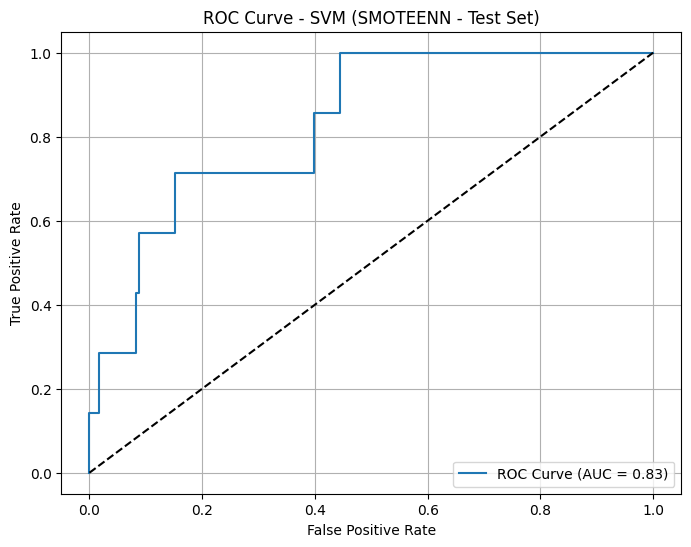

Average Precision (AP) (SVM): 0.3020


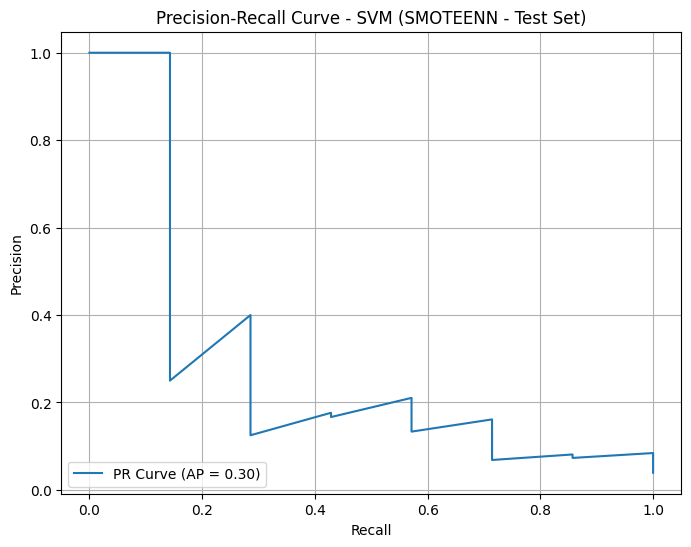

In [ ]:
# ------------------------------------------------------
# SVM ROC_AUC and PR Curve visualization
# ------------------------------------------------------


# NOTE: refitting to full training set with the best hyperparameters


# resample training set with SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled_svm, y_train_resampled_svm = smoteenn.fit_resample(X_train, y_train)




# define the best SVM model
best_svm = SVC(
    kernel='rbf',
    gamma='auto',
    C=np.float64(0.1),
    class_weight='balanced',
    probability=True,
    random_state=42
)




# fit model
best_svm.fit(X_train_resampled_svm, y_train_resampled_svm)





# predict on the test set
y_pred_svm = best_svm.predict(X_test)
y_proba_svm = best_svm.predict_proba(X_test)[:, 1]





# ------------------------------------------------------
# ROC-AUC Visualization


# Compute ROC curve and AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_proba_svm)
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"ROC AUC (SVM): {roc_auc_svm:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'ROC Curve (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM (SMOTEENN - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





# ------------------------------------------------------
# Precision-Recall Curve Visualization


# Compute Precision-Recall curve
precision_svm, recall_svm, thresholds_pr_svm = precision_recall_curve(y_test, y_proba_svm)

# Compute Average Precision score
ap_score_svm = average_precision_score(y_test, y_proba_svm)
print(f"Average Precision (AP) (SVM): {ap_score_svm:.4f}")

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_svm, precision_svm, label=f'PR Curve (AP = {ap_score_svm:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM (SMOTEENN - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# XGBoost

In [ ]:
# ------------------------------------------------------------------------------
# XGBoost
# ------------------------------------------------------------------------------

# pipeline
xgb_pipeline = Pipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])



# hyperparameter search space
xgb_param_dist = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7, 10],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.3],
    'xgb__reg_alpha': [0, 0.01, 0.1],
    'xgb__reg_lambda': [1, 1.5, 2.0]
}



# RandomizedSearchCV with Stratified 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)




# fit the model (tuning + training inside folds)
xgb_search.fit(X_train, y_train)



# best parameters
best_xgb_params = xgb_search.best_params_
print("Best hyperparameters (XGBoost):", best_xgb_params)




# retrain best model on full training data (with SMOTE-ENN)
smoteenn = SMOTEENN(random_state=42)
X_train_resampled_xgb, y_train_resampled_xgb = smoteenn.fit_resample(X_train, y_train)




# Rebuilding best XGB model
final_xgb = XGBClassifier(
    n_estimators=best_xgb_params['xgb__n_estimators'],
    max_depth=best_xgb_params['xgb__max_depth'],
    learning_rate=best_xgb_params['xgb__learning_rate'],
    subsample=best_xgb_params['xgb__subsample'],
    colsample_bytree=best_xgb_params['xgb__colsample_bytree'],
    gamma=best_xgb_params['xgb__gamma'],
    reg_alpha=best_xgb_params['xgb__reg_alpha'],
    reg_lambda=best_xgb_params['xgb__reg_lambda'],
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

final_xgb.fit(X_train_resampled_xgb, y_train_resampled_xgb)






# Evaluate on TRAINING set
y_train_pred_xgb = final_xgb.predict(X_train_resampled_xgb)
y_train_proba_xgb = final_xgb.predict_proba(X_train_resampled_xgb)[:, 1]

print("\nTraining Performance (XGBoost):")
print(f"Precision: {precision_score(y_train_resampled_xgb, y_train_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_train_resampled_xgb, y_train_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled_xgb, y_train_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled_xgb, y_train_proba_xgb):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled_xgb, y_train_pred_xgb):.4f}")







# Evaluate on TEST set
y_pred_xgb = final_xgb.predict(X_test)
y_proba_xgb = final_xgb.predict_proba(X_test)[:, 1]

precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
cohen_kappa_xgb = cohen_kappa_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\nTest Performance (XGBoost):")
print(classification_report(y_test, y_pred_xgb))
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"ROC AUC: {roc_auc_xgb:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_xgb:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_xgb)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:01:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:01:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best hyperparameters (XGBoost): {'xgb__subsample': 1.0, 'xgb__reg_lambda': 1.5, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 200, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.6}

Training Performance (XGBoost):
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Cohen’s Kappa: 1.0000

Test Performance (XGBoost):
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       171
           1       0.25      0.57      0.35         7

    accuracy                           0.92       178
   macro avg       0.62      0.75      0.65       178
weighted avg       0.95      0.92      0.93       178

Precision: 0.2500
Recall: 0.5714
F1 Score: 0.3478
ROC AUC: 0.8304
Cohen’s Kappa: 0.3101

Confusion Matrix:
 [[159  12]
 [  3   4]]


ROC AUC (XGBoost): 0.8304


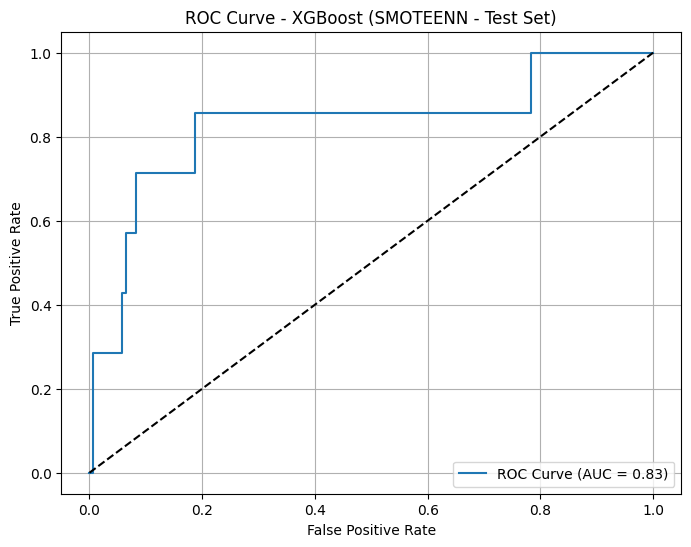

Average Precision (AP) (XGBoost): 0.3050


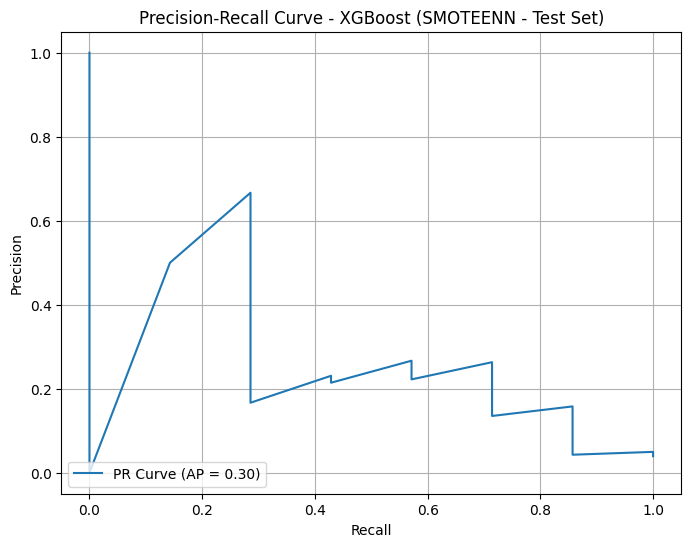

In [ ]:
# ------------------------------------------------------
# ROC-AUC Curve XGB Model


# Compute ROC curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"ROC AUC (XGBoost): {roc_auc_xgb:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'ROC Curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (SMOTEENN - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# ------------------------------------------------------
# Precision-Recall Curve


# Compute Precision-Recall curve
precision_xgb, recall_xgb, thresholds_pr_xgb = precision_recall_curve(y_test, y_proba_xgb)


# Compute Average Precision (AP) score
ap_score_xgb = average_precision_score(y_test, y_proba_xgb)
print(f"Average Precision (AP) (XGBoost): {ap_score_xgb:.4f}")


# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, label=f'PR Curve (AP = {ap_score_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost (SMOTEENN - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# TabNet

In [ ]:
!pip install pytorch-tabnet
!pip install optuna # Hyperparameter tuning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 801.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
# ------------------------------------------------------------------------------
# TabNet with SMOTE-ENN inside CV and Optuna hyperparameter tuning (DETERMINISTIC)
# ------------------------------------------------------------------------------

# Set full random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Apply immediately at the start

# ----------------------------




# preprocess datatypes
X_train_fixed = X_train.copy()
X_test_fixed = X_test.copy()
bool_cols = X_train_fixed.select_dtypes(include='bool').columns
X_train_fixed[bool_cols] = X_train_fixed[bool_cols].astype(int)
X_test_fixed[bool_cols] = X_test_fixed[bool_cols].astype(int)
X_train_fixed = X_train_fixed.astype(np.float32)
X_test_fixed = X_test_fixed.astype(np.float32)

X_np = X_train_fixed.to_numpy()
y_np = y_train.to_numpy()






# Optuna objective with SMOTE-ENN inside CV
def objective(trial):
    set_seed(42)  # Set seed inside each trial

    params = {
        "n_d": trial.suggest_int("n_d", 8, 64, step=8),
        "n_a": trial.suggest_int("n_a", 8, 64, step=8),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-1, log=True),
        "optimizer_params": {"lr": trial.suggest_float("lr", 1e-3, 1e-1, log=True)},
        "mask_type": "entmax",
        "scheduler_fn": torch.optim.lr_scheduler.StepLR,
        "scheduler_params": {"step_size": 10, "gamma": 0.9},
        "verbose": 0,
        "seed": 42
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X_np, y_np):
        X_train_fold, y_train_fold = X_np[train_idx], y_np[train_idx]
        X_val_fold, y_val_fold = X_np[val_idx], y_np[val_idx]


        # SMOTE only applied to the training folds
        X_resampled, y_resampled = SMOTEENN(random_state=42).fit_resample(X_train_fold, y_train_fold)

        model = TabNetClassifier(**params)
        model.fit(
            X_resampled, y_resampled,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric=["balanced_accuracy"],
            max_epochs=100,
            patience=10,
            batch_size=256,
            virtual_batch_size=128
        )

        preds = model.predict(X_val_fold)
        scores.append(f1_score(y_val_fold, preds))

    return np.mean(scores)





# Optuna tuning with fixed-seed sampler
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)  # seed
)
study.optimize(objective, n_trials=30, timeout=600)





# Retrain on full SMOTE-ENN-resampled training data with best params
best_params = study.best_params
print("Best TabNet Parameters:", best_params)

X_train_resampled, y_train_resampled = SMOTEENN(random_state=42).fit_resample(X_np, y_np)

final_model = TabNetClassifier(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_params={"lr": best_params["lr"]},
    mask_type="entmax",
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size": 10, "gamma": 0.9},
    verbose=0,
    seed=42
)

final_model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_train_resampled, y_train_resampled)],
    eval_metric=["balanced_accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)




# Evaluate on training set
y_train_pred = final_model.predict(X_train_resampled)
y_train_proba = final_model.predict_proba(X_train_resampled)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train_resampled, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled, y_train_pred):.4f}")




# Evaluate on test set
X_test_np = X_test_fixed.to_numpy()
y_test_np = y_test.to_numpy()

y_test_pred = final_model.predict(X_test_np)
y_test_proba = final_model.predict_proba(X_test_np)[:, 1]

print("\nTest Performance:")
print(classification_report(y_test_np, y_test_pred))
print(f"Precision: {precision_score(y_test_np, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test_np, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test_np, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_np, y_test_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_test_np, y_test_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test_np, y_test_pred))



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.64706


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.60294


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_balanced_accuracy = 0.73897


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.58971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.72647


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_balanced_accuracy = 0.84559


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.63725


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_balanced_accuracy = 0.83211


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.71691


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.76765


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.75735


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.73529


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_balanced_accuracy = 0.78676


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.70882


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.71691


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.64706


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.52451


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.70343


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.61765


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.70515


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_balanced_accuracy = 0.88235


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.58946


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.72426


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_balanced_accuracy = 0.68603


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.70515


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.72917


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.68627


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_balanced_accuracy = 0.72304


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_balanced_accuracy = 0.68971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.71912


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.6201


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.57108


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.63603


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.47279


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.75662


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.78309


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.7402


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.71691


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.56471


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.82353


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.72181


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_balanced_accuracy = 0.71078


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.87132


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.59044


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.73529


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.63113


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.68995


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 61 with best_epoch = 51 and best_val_0_balanced_accuracy = 0.71936


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.71324


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.66397


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.69608


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.6826


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.78676


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.57206


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.73088


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.73775


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.63725


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.81985


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.76103


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.72353


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.76961


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.59191


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.72672


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.66029


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_balanced_accuracy = 0.80441


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.68137


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.68627


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.71814


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.60074


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.68971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.79902


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.71324


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.84559


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.68235


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.57132


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.85294


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.77696


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.77941


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.70882


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_balanced_accuracy = 0.76103


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.76838


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.69608


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_balanced_accuracy = 0.79044


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.69044


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.81544


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.8174


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.63848


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.81618


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.62059


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.70221


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.67279


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.7549


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_balanced_accuracy = 0.82353


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.49779


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_balanced_accuracy = 0.78676


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.91544


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_balanced_accuracy = 0.82108


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.82475


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.60074


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.76397


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.81618


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_balanced_accuracy = 0.6973


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.81985


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.66471


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.63088


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.84926


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.66789


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.8174


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.53088


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.775


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.79167


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.66544


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.67157


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.60515


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.80074


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_balanced_accuracy = 0.82475


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_balanced_accuracy = 0.73284


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.65686


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5875


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.73015


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.6973


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.77328


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.79779


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.53162


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.78603


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.8125


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_balanced_accuracy = 0.73652


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_balanced_accuracy = 0.74755


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_balanced_accuracy = 0.75662


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.79412


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.85662


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_balanced_accuracy = 0.77328


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.78309


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_balanced_accuracy = 0.72721


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.89706


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.81373


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.71446


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.77206


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.56471


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.75


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.71078


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.67525


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_balanced_accuracy = 0.78799


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.63456


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.76029


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.74142


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_balanced_accuracy = 0.66667


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.67647


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.72426


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.69853
Best TabNet Parameters: {'n_d': 48, 'n_a': 56, 'n_steps': 5, 'gamma': 1.6732717907646601, 'lambda_sparse': 0.00324520160171568, 'lr': 0.0744936724004652}


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 97 with best_epoch = 87 and best_val_0_balanced_accuracy = 1.0


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Training Performance:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Cohen’s Kappa: 1.0000

Test Performance:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       171
           1       0.27      0.57      0.36         7

    accuracy                           0.92       178
   macro avg       0.62      0.75      0.66       178
weighted avg       0.95      0.92      0.93       178

Precision: 0.2667
Recall: 0.5714
F1 Score: 0.3636
ROC AUC: 0.8672
Cohen’s Kappa: 0.3276

Confusion Matrix:
 [[160  11]
 [  3   4]]


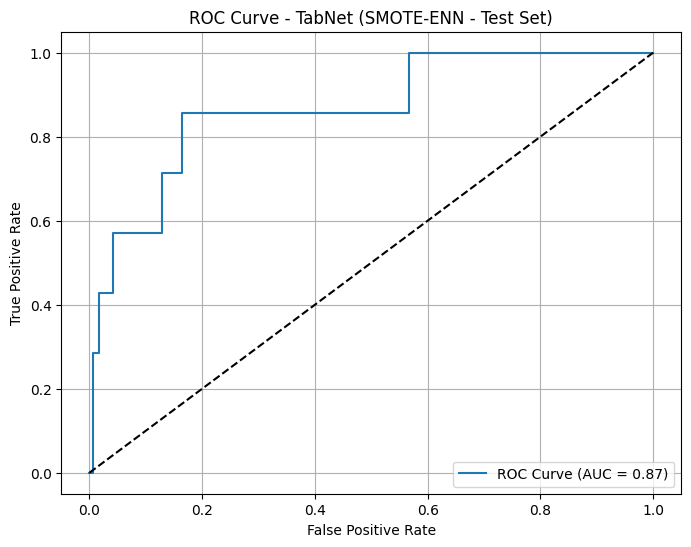

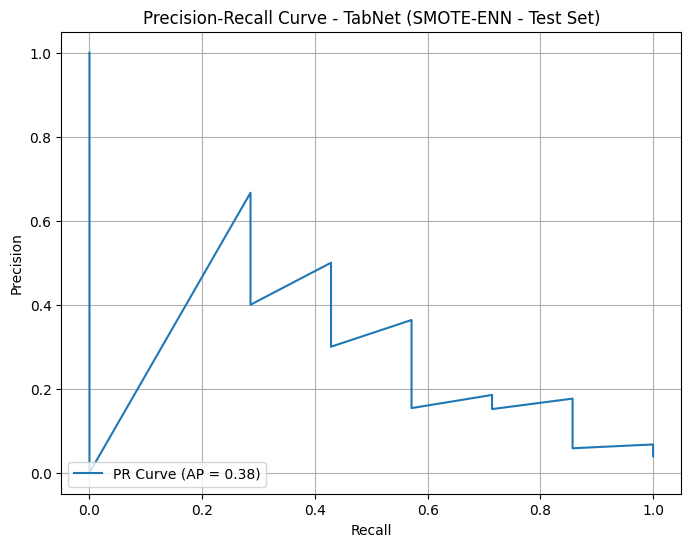

In [ ]:
# -----------------------------------
# ROC-AUC Curve TabNet
# -----------------------------------



fpr, tpr, thresholds = roc_curve(y_test_np, y_test_proba)
roc_auc = roc_auc_score(y_test_np, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TabNet (SMOTE-ENN - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# -----------------------------------
# Precision-Recall Curve

precision, recall, thresholds_pr = precision_recall_curve(y_test_np, y_test_proba)
ap_score = average_precision_score(y_test_np, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - TabNet (SMOTE-ENN - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()



Top 20 Important Features:
         feature  importance
0     cesd_log_z    0.340007
1         psyt_1    0.097164
2          sex_2    0.092794
3     qcae_cog_z    0.068642
4   stud_h_log_z    0.065353
5         jspe_z    0.064825
6       health_3    0.064746
7     qcae_aff_z    0.054255
8         part_1    0.028830
9         year_5    0.023617
10        year_3    0.015549
11        year_2    0.014768
12         age_z    0.013241
13         job_1    0.011820
14   erec_mean_z    0.011034
15      health_5    0.010454
16      health_2    0.009064
17        amsp_z    0.006728
18      stai_t_z    0.004697
19      health_4    0.002373


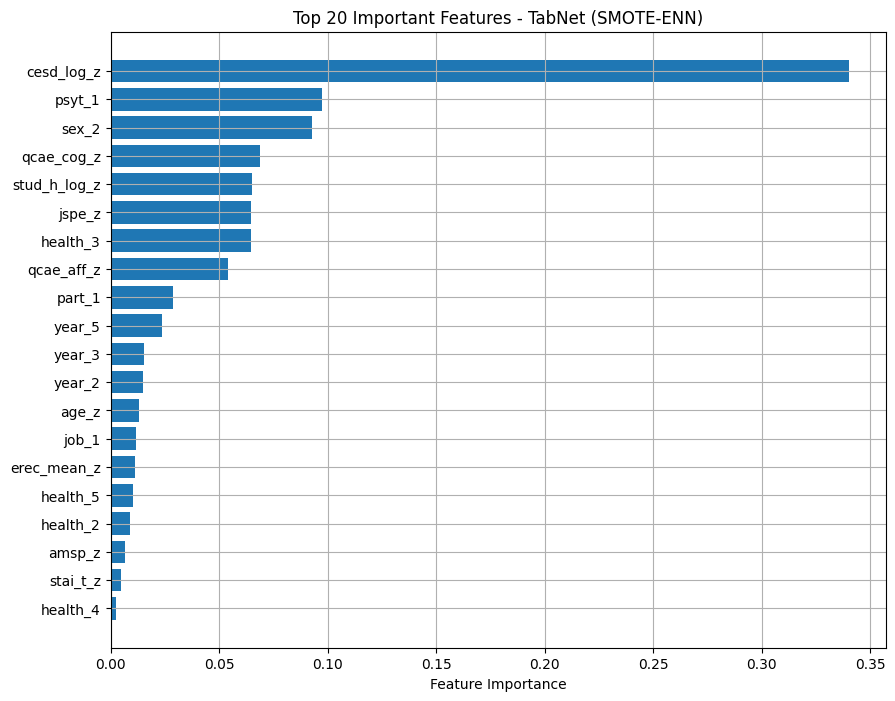

In [ ]:
# ------------------------------------------------------
# Feature Importance for TabNet model



# feature importances
feature_importances = final_model.feature_importances_





# DataFrame required
feat_importance_df = pd.DataFrame({
    'feature': X_train_fixed.columns,
    'importance': feature_importances
})





# Sort features by importance
feat_importance_df = feat_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)





# Print Top 20 important features
print("\nTop 20 Important Features:")
print(feat_importance_df.head(20))






# Plot Top 20 important features
plt.figure(figsize=(10, 8))
plt.barh(feat_importance_df['feature'][:20][::-1], feat_importance_df['importance'][:20][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features - TabNet (SMOTE-ENN)')
plt.grid(True)
plt.show()
